In [17]:
import sys

sys.path.append("../libs")

CONFIG = {
    "cleaned_dataset": "lending_club_cleaned",
    "feature_dataset_database_file": "../data/feature_store.db",
    "dfs_agg_primitives" : ["mean", "sum", "count", "max", "min", "std"],
    "train_size": 0.75,
    "test_size": 0.15,
    "val_size": 0.10,
    "target": "default",
    "features_to_remove": ['loan_status', 'int_rate', 'debt_settlement_flag']
}

### Loading Data

In [18]:
from feature_dataset import FeatureDataset

fs = FeatureDataset(CONFIG['feature_dataset_database_file'])
df = fs.get_feature_dataset(name=CONFIG['cleaned_dataset'])
df.head()

,id,loan_amnt,funded_amnt,term,int_rate,installment,emp_length,home_ownership,annual_inc,verification_status,...,hardship_flag,deferral_term,hardship_amount,hardship_length,hardship_dpd,orig_projected_additional_accrued_interest,hardship_payoff_balance_amount,hardship_last_payment_amount,debt_settlement_flag,default
0,1077501,5000,5000,36,0.106506,162.87500,10+ years,RENT,24000.0,Verified,...,N,-1,-1.0,-1,-1,-1.0,-1.0,-1.0,N,0.0
1,1077430,2500,2500,60,0.152710,59.84375,< 1 year,RENT,30000.0,Source Verified,...,N,-1,-1.0,-1,-1,-1.0,-1.0,-1.0,N,1.0
2,1077175,2400,2400,36,0.159546,84.31250,10+ years,RENT,12252.0,Not Verified,...,N,-1,-1.0,-1,-1,-1.0,-1.0,-1.0,N,0.0
3,1076863,10000,10000,36,0.134888,339.25000,10+ years,RENT,49200.0,Source Verified,...,N,-1,-1.0,-1,-1,-1.0,-1.0,-1.0,N,0.0
4,1075358,3000,3000,60,0.126953,67.81250,1 year,RENT,80000.0,Source Verified,...,N,-1,-1.0,-1,-1,-1.0,-1.0,-1.0,N,0.0


In [19]:
df['time_of_banking_days'] = (df['issue_d'] - df['earliest_cr_line']).dt.days
df['time_of_banking_months'] = (df['issue_d'].dt.year - df['earliest_cr_line'].dt.year) * 12 + (df['issue_d'].dt.month - df['earliest_cr_line'].dt.month)

In [21]:
df = df.dropna(subset=['default'])
features_to_remove = CONFIG["features_to_remove"]
print(f"Features to remove: {CONFIG['features_to_remove']}")

Features to remove: ['loan_status', 'int_rate', 'debt_settlement_flag']


In [22]:
df = df.drop(columns=features_to_remove)

In [24]:
df['target'] = df[CONFIG['target']]

### Generation Features



In [25]:
# from processing.deep_feature_synthesis import DeepFeatureSynthesisPipeline
# deep_feature_synthetic = DeepFeatureSynthesisPipeline(name="loan_data", aggs_primitives=CONFIG['dfs_agg_primitives'])


In [26]:
# X = deep_feature_synthetic.transform(X).reset_index()


In [27]:
cat_features = list(df.select_dtypes(include=['category']).columns)
df[cat_features] = df[cat_features].astype(str).fillna('missing')

### Split Data

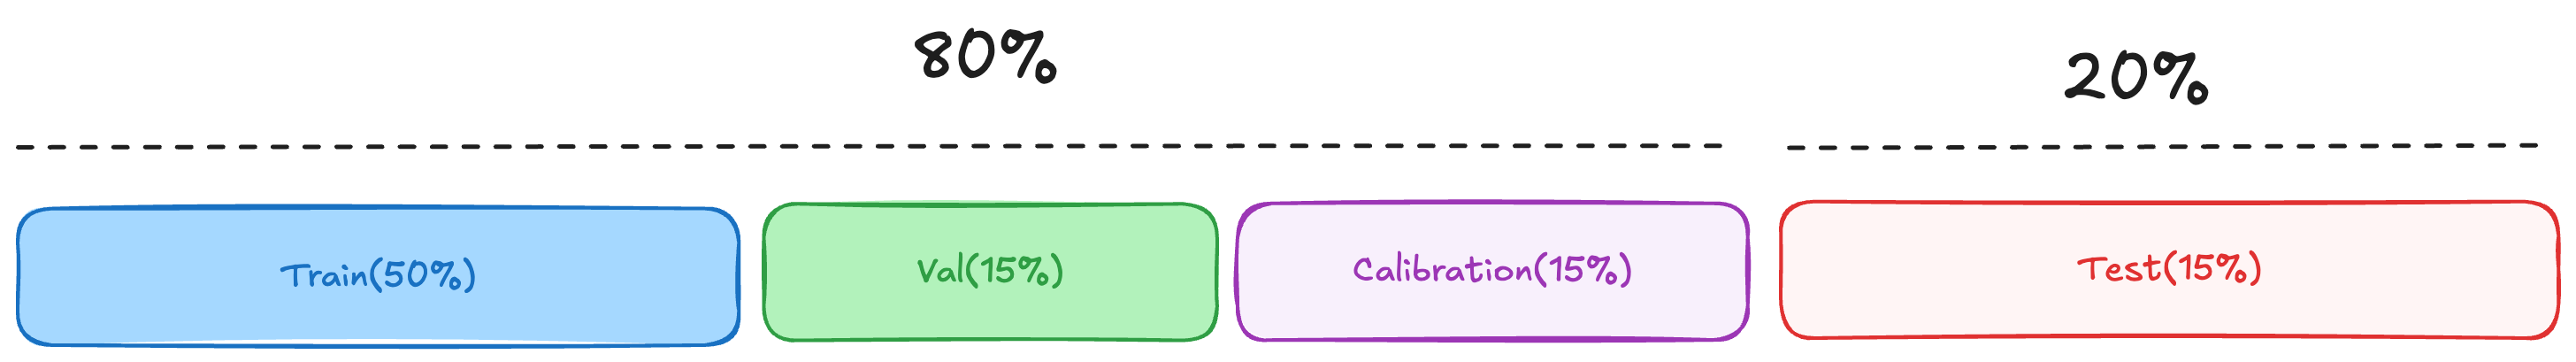

In [28]:
df.head()

,id,loan_amnt,funded_amnt,term,installment,emp_length,home_ownership,annual_inc,verification_status,issue_d,...,hardship_amount,hardship_length,hardship_dpd,orig_projected_additional_accrued_interest,hardship_payoff_balance_amount,hardship_last_payment_amount,default,time_of_banking_days,time_of_banking_months,target
0,1077501,5000,5000,36,162.87500,10+ years,RENT,24000.0,Verified,2011-12-01,...,-1.0,-1,-1,-1.0,-1.0,-1.0,0.0,9830,323,0.0
1,1077430,2500,2500,60,59.84375,< 1 year,RENT,30000.0,Source Verified,2011-12-01,...,-1.0,-1,-1,-1.0,-1.0,-1.0,1.0,4627,152,1.0
2,1077175,2400,2400,36,84.31250,10+ years,RENT,12252.0,Not Verified,2011-12-01,...,-1.0,-1,-1,-1.0,-1.0,-1.0,0.0,3682,121,0.0
3,1076863,10000,10000,36,339.25000,10+ years,RENT,49200.0,Source Verified,2011-12-01,...,-1.0,-1,-1,-1.0,-1.0,-1.0,0.0,5782,190,0.0
4,1075358,3000,3000,60,67.81250,1 year,RENT,80000.0,Source Verified,2011-12-01,...,-1.0,-1,-1,-1.0,-1.0,-1.0,0.0,5813,191,0.0


In [29]:
from processing.data_splitter import TimeSplitVerifier

verifier = TimeSplitVerifier(df, "issue_d")
results = verifier.run_tests()

 Coluna de data 'issue_d' identificada e processada.
Running stats tests...
                                        Test  Significance  Threshold  \
0                             KS Test for id           0.0       0.05   
1                      KS Test for loan_amnt           0.0       0.05   
2                    KS Test for funded_amnt           0.0       0.05   
3                           KS Test for term           0.0       0.05   
4                    KS Test for installment           0.0       0.05   
..                                       ...           ...        ...   
201              Chi-Square Test for purpose           0.0       0.05   
202           Chi-Square Test for addr_state           0.0       0.05   
203  Chi-Square Test for initial_list_status           0.0       0.05   
204     Chi-Square Test for application_type           0.0       0.05   
205        Chi-Square Test for hardship_flag           0.0       0.05   

          Result  
0    Significant  
1    Sign

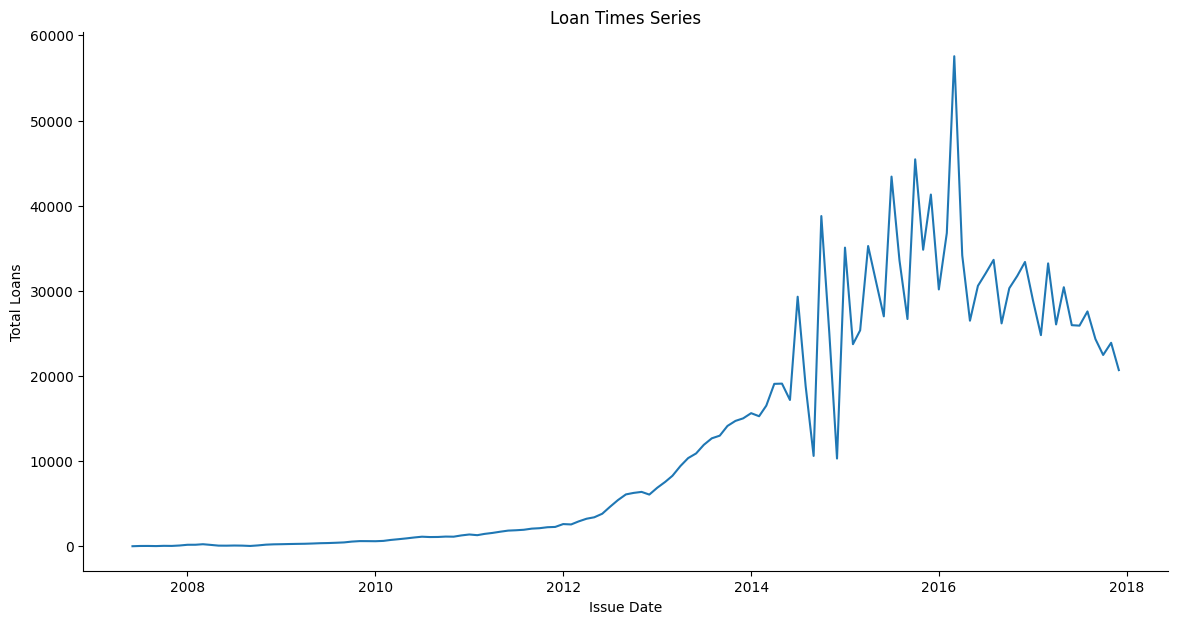

In [30]:
import seaborn as sns
import matplotlib.pyplot as plt
plt.figure(figsize=(14, 7))

df_aux = df.groupby('issue_d')['id'].count().reset_index()
ax = sns.lineplot(df_aux, x='issue_d', y='id')
plt.xlabel("Issue Date")
plt.ylabel("Total Loans")
plt.title("Loan Times Series")

sns.despine()

plt.show()

In [58]:
import numpy as np
import seaborn as sns
df_training, df_testing = np.split(df.sort_values(by='issue_d'), [int(.80 *len(df))])
df_training, df_calibration = np.split(df_training.sort_values(by='issue_d'), [int(.65 *len(df_training))])


/Users/marcos.mota/projects/personal/lending_club/.venv/lib/python3.11/site-packages/numpy/core/fromnumeric.py:59: FutureWarning: 'DataFrame.swapaxes' is deprecated and will be removed in a future version. Please use 'DataFrame.transpose' instead.
  return bound(*args, **kwds)


In [59]:
print("Whole DataFrame:")
print(f"Start Date: {df['issue_d'].min()}")
print(f"End Date: {df['issue_d'].max()}")


print("\nTraining DataFrame:")
print(f"Start Date: {df_training['issue_d'].min()}")
print(f"End Date: {df_training['issue_d'].max()}")

print("\nCalibration DataFrame:")
print(f"Start Date: {df_calibration['issue_d'].min()}")
print(f"End Date: {df_calibration['issue_d'].max()}")

print("\nTesting DataFrame:")
print(f"Start Date: {df_testing['issue_d'].min()}")
print(f"End Date: {df_testing['issue_d'].max()}")

Whole DataFrame:
Start Date: 2007-06-01 00:00:00
End Date: 2017-12-01 00:00:00

Training DataFrame:
Start Date: 2007-06-01 00:00:00
End Date: 2015-11-01 00:00:00

Calibration DataFrame:
Start Date: 2015-11-01 00:00:00
End Date: 2016-12-01 00:00:00

Testing DataFrame:
Start Date: 2016-12-01 00:00:00
End Date: 2017-12-01 00:00:00


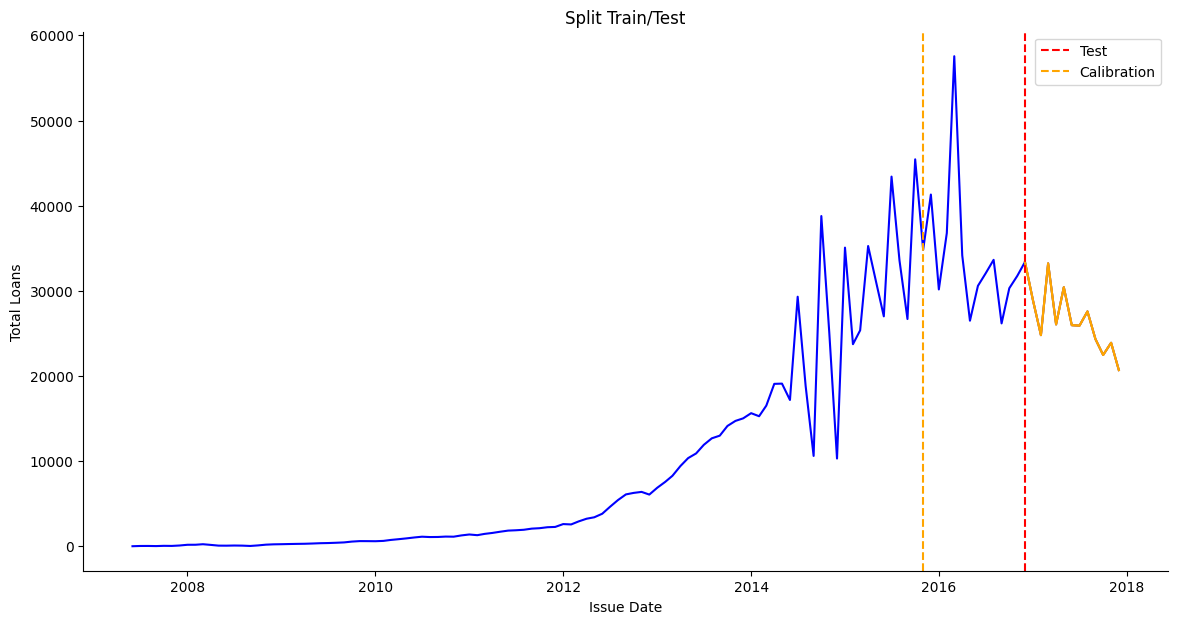

In [60]:
import matplotlib.pyplot as plt
import pandas as pd

plt.figure(figsize=(14, 7))
df_gp = df.groupby('issue_d')['id'].count().reset_index()
ax = sns.lineplot(data=df_gp, x='issue_d', y='id')

test_start_date = df_testing['issue_d'].min()
calibration_start_date = df_calibration['issue_d'].min()

line = ax.get_lines()[0]
x_data = pd.to_datetime(line.get_xdata(), unit='D', origin='unix')
y_data = line.get_ydata()
line.set_color('blue')
mask = x_data >= test_start_date
ax.plot(x_data[mask], y_data[mask], color='red')

line = ax.get_lines()[1]
x_data = pd.to_datetime(line.get_xdata(), unit='D', origin='unix')
y_data = line.get_ydata()
line.set_color('orange')
mask = x_data >= calibration_start_date
ax.plot(x_data[mask], y_data[mask], color='orange')

plt.axvline(test_start_date, color='red', linestyle='--', label='Test')
plt.axvline(calibration_start_date, color='orange', linestyle='--', label='Calibration')


plt.xlabel("Issue Date")
plt.ylabel("Total Loans")
plt.title("Split Train/Test")
plt.legend()
sns.despine()

plt.show()

In [61]:
fs.create_feature_dataset(name="training",dataset=df_training, version=1)
fs.create_feature_dataset(name="calibration",dataset=df_calibration, version=1)
fs.create_feature_dataset(name="testing",dataset=df_testing, version=1)